# Audio-based recognition of EU euro (€)

## Load Datasets
Labels

0: 1 Cent

1: 10 Cent 

2: 2 Euro


In [1]:
import glob
from scipy.io import wavfile
import numpy as np

data1Cent = [wavfile.read(infile)[1] for infile in glob.glob('coins_audio_data/1_cent/*.wav')]
data10Cent = [wavfile.read(infile)[1] for infile in glob.glob('coins_audio_data/10_cent/*.wav')]
data2Euro = [wavfile.read(infile)[1] for infile in glob.glob('coins_audio_data/2_euro/*.wav')]

# Combine into one sample set
data = np.array(data1Cent + data10Cent + data2Euro)
data = data.T
data = np.float32(data)
# Labels:
labels = np.zeros(150)
labels[50:100] += 1
labels[100:150] += 2

## Part 2: Signal conditioning
1. Normalisation
1. Find ROI
1. Filtering?

In [2]:
import matplotlib.pyplot as plt

# Normalise data
data = data / data.max(axis=0)

plt.plot(data[:,23])
plt.show()

In [3]:
# Find the region of interest
# Use thresholding to remove the recorded data before the coin hits
mark = np.zeros(data.shape[1], dtype=int)

for i in range(data.shape[1]): 
    for j in range(data.shape[0]):
        if(data[j, i] > 0.7):
            mark[i] = j
            break
#plt.figure(2)
#plt.clf()
#plt.scatter(range(len(mark)), (mark/(44100.0)))
#plt.xlabel('Sample number')
#plt.ylabel('Starting time')
#plt.show()

(88200, 150)


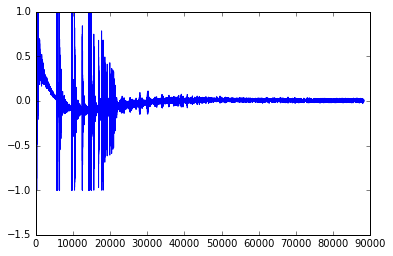

In [4]:
# remove data before mark and data two seconds after mark
data_roi = np.zeros((44100*2, data.shape[1]))
print data_roi.shape
for i, m in enumerate(mark):
    data_roi[:, i] = data[m-100:m+2*44100-100, i]

plt.plot(data_roi[:,23])
plt.show()

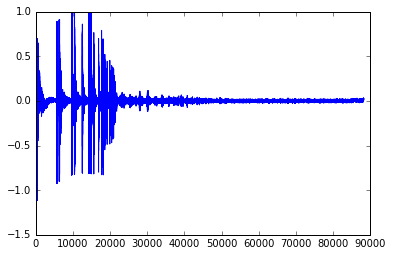

In [5]:
# Filter data, remove DC component
from scipy import signal
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

data_roi_filtered = np.zeros((44100*2, data.shape[1]))
cutoff = 10 # 10 Hz cutoff frequency
fs = 44100  # sampling frequency
order = 5   # Filter order
for i in range(data_roi.shape[1]):
    filtered = butter_highpass_filter(data_roi[:, i], cutoff, fs, order)
    filtered = filtered / filtered.max(axis=0) 
    data_roi_filtered[:, i] = filtered    

plt.plot(data_roi_filtered[:, 23])
plt.show()

In [6]:
# Store the filtered, normalised region of interest of each recording into a numpy array
for i in range(data_roi_filtered.shape[1]):
    filename = '{}/{}{}.npy'.format("coins_roi", "coins_roi_", i)
    np.save(filename, data_roi_filtered[:, i])
    
# test = np.load("coins_roi/coins_roi_23.npy")
# plt.plot(test)
# plt.show()

## Part 3: Feature computation
1. FFT
1. Spectrum (time vs freq)

In [7]:
# Load numpy arrays of data


In [170]:
from scipy.fftpack import fft
  
N = 88200
T = 1.0 / 44100
data_fft = [fft(data_roi_filtered[:, i]) for i in range(data_roi_filtered.shape[1])]
data_fft = np.array([data_fft[i][0:N//2] for i in range(len(data_fft))])
print data_fft.shape

(150, 44100)


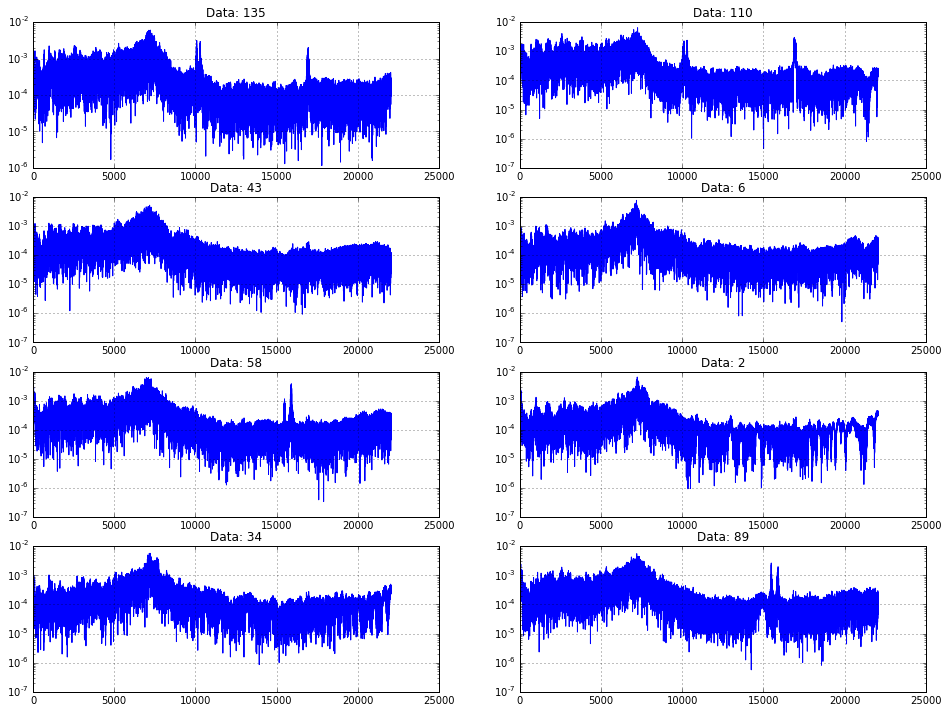

In [140]:
# Plot some frequency plots from randomly chosen samples
import random
N = 88200
T = 1.0 / 44100
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.rcParams["figure.figsize"] = [16, 12]
rows = 4
randnums = [random.randint(0, 149) for i in range(rows*2)]
f, splt = plt.subplots(rows,2)
for i, p in enumerate(randnums):
    splt[i%rows, i/rows].semilogy(xf, 2.0/N * np.abs(data_fft[p]))
    splt[i%rows, i/rows].set_title("Data: {}".format(p))
    splt[i%rows, i/rows].grid()
plt.show()

From the frequency plots we can see that:

- 1 cent coins (data 0-49) have no distinguishable peaks
- 10 cent coins (data 50-99) have a distinguishable double peak around 16.000 Hz
- 2 euro coins (data 100-149) have a distinguishable peak around 17.000 Hz, and a double peak around 10.500 Hz

Knowing this, we will extract the frequency spectrum in the 10-18 KHz region and create frequency bins that will serve as our features. 

60 bins of 100 Hz width will be used first to see if one can classify coins using these as features, each bin will have a single value showing how much of that frequency region is in the recorded audio.


## Part 4: Feature extraction

In [209]:
# Extract the frequency area 10-18 KHz from each sample
plt.rcParams["figure.figsize"] = [12, 8]
N = 88200
T = 1.0 / 44100
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
bottom = int(44100*(15000.0/22050))
top = int(44100*(18000.0/22050))
print data_fft.shape
data_fft_roi = data_fft[:, bottom:top]
print data_fft_roi.shape

(150, 44100)
(150, 6000)


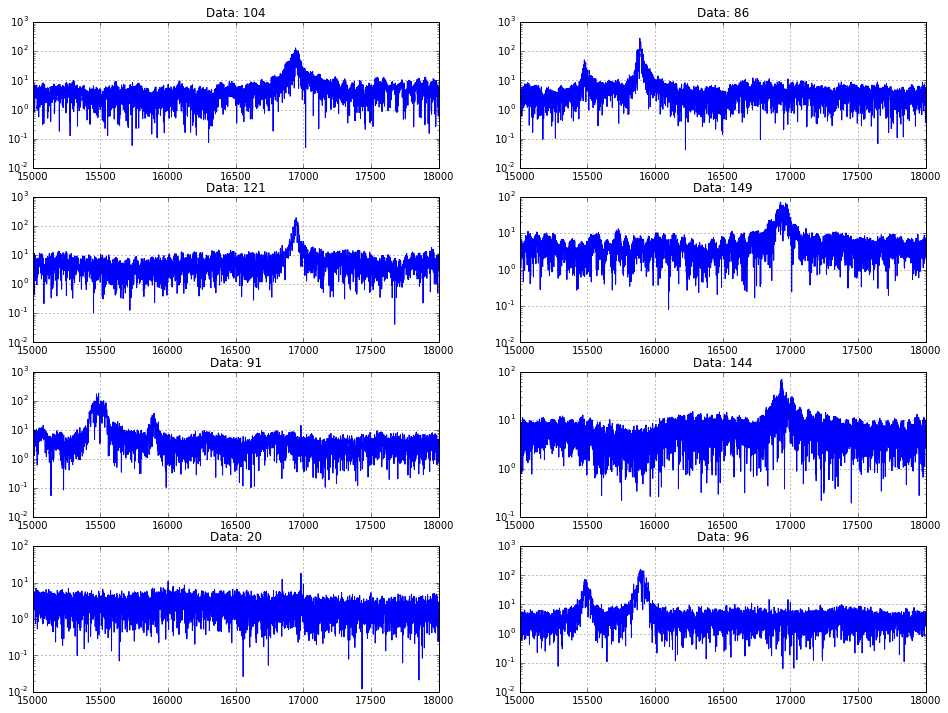

In [204]:
# Plot some frequency plots from randomly chosen samples
plt.rcParams["figure.figsize"] = [16, 12]
rows = 4
randnums = [random.randint(0, 149) for i in range(rows*2)]
f, splt = plt.subplots(rows,2)
for i, p in enumerate(randnums):
    splt[i%rows, i/rows].semilogy(xf[bottom:top], np.abs(data_fft_roi[p]))
    splt[i%rows, i/rows].set_title("Data: {}".format(p))
    splt[i%rows, i/rows].grid()
plt.show()

6000


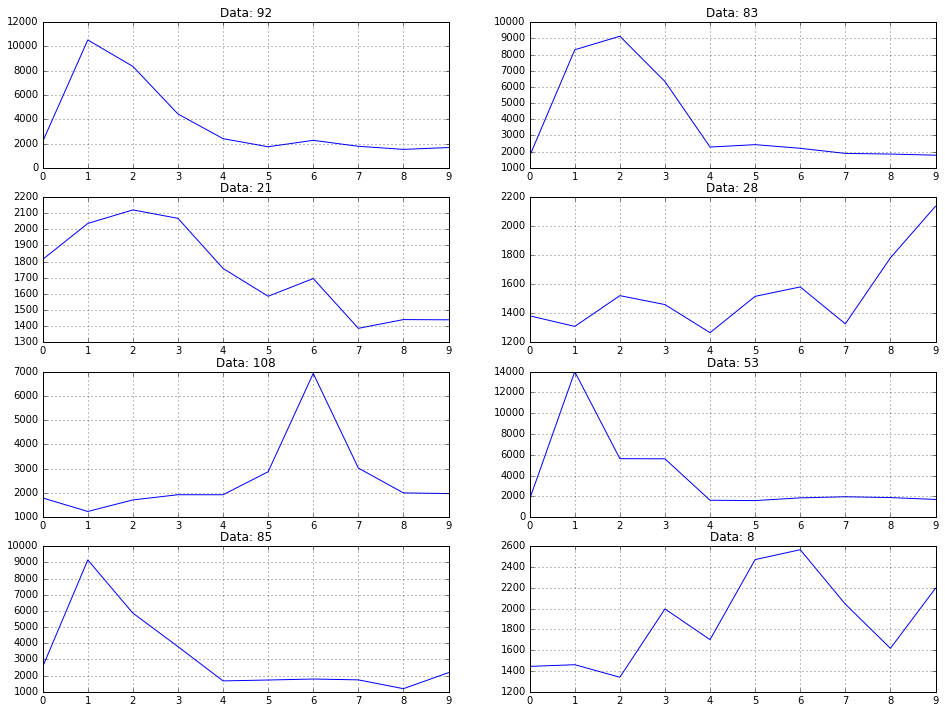

In [281]:
# Create bins for frequency content
print data_fft_roi.shape[1]
bins = 10
bin_size = float(data_fft_roi.shape[1]/(2*bins)) # in Hz
step = int(44100*(bin_size/22050)) # Bin size in samples
data_bin = np.zeros((data_fft_roi.shape[0], (int(data_fft_roi.shape[1]/step))))
for i in range(data_fft_roi.shape[0]):
    data_bin[i] = [sum(abs(data_fft_roi[i, idx*step:(idx+1)*step-1])) for idx in range(data_fft_roi.shape[1]/step)]
    
plt.rcParams["figure.figsize"] = [16, 12]
rows = 4
#randnums = [random.randint(0, 149) for i in range(rows*2)]
f, splt = plt.subplots(rows,2)
for i, p in enumerate(randnums):
    splt[i%rows, i/rows].plot(data_bin[p])
    splt[i%rows, i/rows].set_title("Data: {}".format(p))
    splt[i%rows, i/rows].grid()
plt.show()


## Part 5: Training classifier

In [310]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# Split into training and test sets
xTrain, xTest, yTrain, yTest = train_test_split(data_bin, labels, test_size=0.2)


clf = LinearDiscriminantAnalysis(n_components=2)
clf = clf.fit(xTrain, yTrain)

## Part 6: Testing classifier

In [311]:
from sklearn.metrics import confusion_matrix

predict = clf.predict(xTest)

print(confusion_matrix(yTest, predict))
print(clf.score(xTest, yTest))

[[11  1  0]
 [ 0 10  0]
 [ 0  0  8]]
0.966666666667


# Part 7: Visualisation

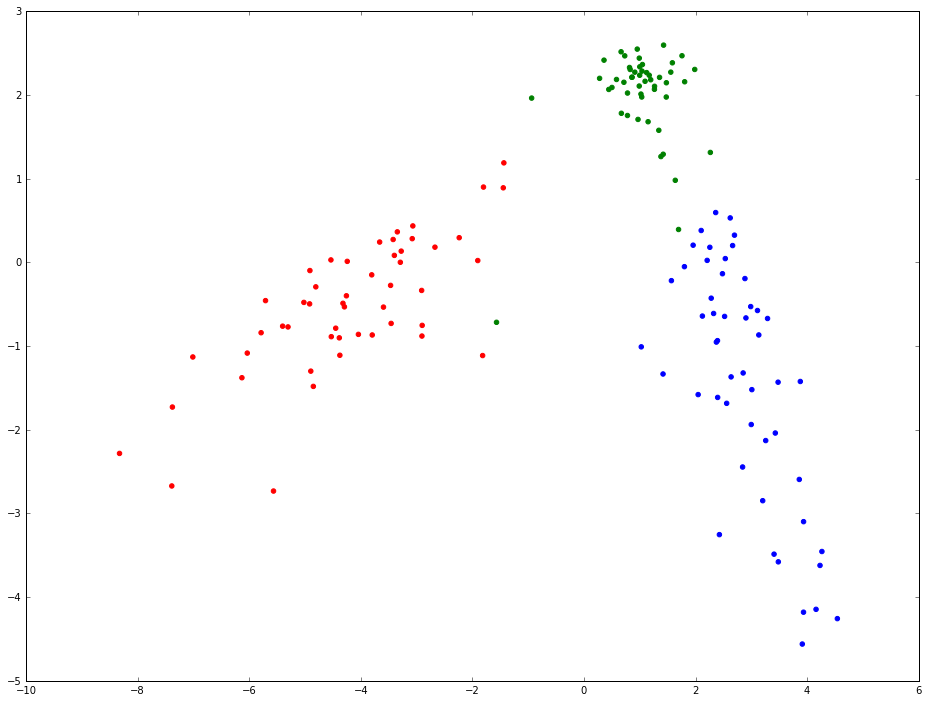

In [312]:
xVis = clf.transform(data_bin)

# 1 cent - Green
# 10 cent - Red
# 2 Euro - Blue
colors = ['red' if int(l)==1 else 'blue' if int(l)==2 else 'green' for l in labels]

plt.scatter(xVis[:,0], xVis[:,1], color=colors)
plt.show()